## Objetivos desta branch
### Criar gráficos que expressem melhor os resultados do modelo.

 + Um mapa de classificação para cada critério
 + Um gráfico de barras para mostrar a relação entre a classificação e as denúncias
 + Um mapeamento somente das denúncias.
 - Criar um gráfico barras empilhadas para mostrar a porcentagem por critério.
 - Criar uma tabela com os nomes dos municípios e suas classificações. dividindo a tabela em 8 colunas para mostrar todos os municípios.
 


In [25]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        #if munic['nome'] != 'Mojuí dos Campos':
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


    90201: Delegacia especializada no Atendimento à Mulher
    90358: Ações de Enfrentamento à Violência contra a Mulher
    90626: Direitos ou política para mulheres
    90335: Executa programas e ações para grupos específicos - Mulheres
    90640: Políticas ou programas na área de direitos humanos - Proteção de mulheres vítimas de violência doméstica 
    90272: Ações Socioeducativas - Violência doméstica e de gênero
    90397: Constituição de centros de referência e atendimento em direitos humanos

In [26]:
indicators = ['90201','90335','90358','90626','90640', '90272', '90397']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df.iterrows():
        if i != (len(df)):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [27]:
ExcelentEquipaments = [90201, 90358, 90272]
GoodEquipaments = [90626, 90640]
okEquipaments = [90335, 90397]

if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        if indicador['id'] in ExcelentEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 1.5 if x['2019']  == 'Sim' else 0)

        elif indicador['id'] in GoodEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 0.5 if x['2019']  == 'Sim' else 0)

        else:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 0.2 if x['2019']  == 'Sim' else 0)

        df_munic = pd.merge(df_munic, df_temp, on="id")

In [28]:
df_munic

,id,localidade,90201,90272,90335,90358,90397,90626,90640
0,150010,Abaetetuba,1.5,0.0,0.2,0.0,0.0,0.5,0.5
1,150013,Abel Figueiredo,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,150020,Acará,0.0,0.0,0.2,0.0,0.0,0.5,0.5
3,150030,Afuá,0.0,0.0,0.2,0.0,0.0,0.5,0.5
4,150034,Água Azul do Norte,0.0,0.0,0.0,0.0,0.0,0.0,0.5
...,...,...,...,...,...,...,...,...,...
139,150815,Uruará,0.0,0.0,0.2,0.0,0.0,0.0,0.0
140,150820,Vigia,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,150830,Viseu,0.0,0.0,0.2,0.0,0.0,0.0,0.0
142,150835,Vitória do Xingu,0.0,0.0,0.2,1.5,0.0,0.5,0.5


  90201: Delegacia especializada no Atendimento à Mulher
  90358: Enfrentamento à Violência contra a Mulher
  90272: Ações Socioeducativas - Violência doméstica e de gênero

  90626: Direitos ou política para mulheres
  90640: Políticas ou programas na área de direitos humanos - Proteção de mulheres vítimas de violência doméstica 
  
    90335: Executa programas e ações para grupos específicos - Mulheres
    90397: Constituição de centros de referência e atendimento em direitos humanos

In [29]:
df_munic['IAP'] = df_munic[90201] + df_munic[90272] + df_munic[90335] + df_munic[90358] + df_munic[90397] + df_munic[90626] + df_munic[90640]

df_munic = df_munic[['id', 'localidade', 'IAP']]

In [30]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [31]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [32]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp =  pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])
df_munic['GINI'] = df_munic.iloc[:, 5:6].apply(lambda x: -x.abs(), axis=1)

In [33]:
df_munic['IAP'] = pd.to_numeric(df_munic['IAP'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [34]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

rng = np.random.RandomState(10)

scaler1 = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler2 = preprocessing.QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=48, copy=True)
scaler3 = preprocessing.PowerTransformer(method="yeo-johnson")
# transform training data & save lambda value


d1 = scaler3.fit_transform(df_munic.iloc[:,2:3])
d2 = scaler2.fit_transform(df_munic.iloc[:,3:4])
d3 = scaler2.fit_transform(df_munic.iloc[:,4:5])
d4 = scaler2.fit_transform(df_munic.iloc[:,5:6])


ds = [d1, d2, d3, d4]

scaled_df = pd.DataFrame()
cont = 2
for i in ds:

    s_df = pd.DataFrame(i, columns=df_munic.iloc[:,cont:cont+1].columns)
    scaled_df = pd.concat([scaled_df, s_df], axis=1)
    cont += 1

scaled_df = pd.concat([df_munic.iloc[:,:2], scaled_df], axis=1)
scaled_df





,id,localidade,IAP,IDH,PIB,GINI
0,150010,Abaetetuba,1.657190,0.874551,-0.292245,-1.073988
1,150013,Abel Figueiredo,0.020884,0.764710,0.213061,0.229884
2,150020,Acará,0.901336,-1.293598,0.404108,0.574460
3,150030,Afuá,0.901336,-1.639976,-0.303275,-0.650837
4,150034,Água Azul do Norte,0.020884,-0.291639,0.632117,0.229884
...,...,...,...,...,...,...
139,150815,Uruará,-0.676405,0.152506,0.374977,-0.203961
140,150820,Vigia,-1.377480,0.733920,-1.353800,0.574460
141,150830,Viseu,-0.676405,-1.120205,-0.785002,0.229884
142,150835,Vitória do Xingu,1.657190,0.386265,2.868427,-0.203961


In [35]:
scaled_df

,id,localidade,IAP,IDH,PIB,GINI
0,150010,Abaetetuba,1.657190,0.874551,-0.292245,-1.073988
1,150013,Abel Figueiredo,0.020884,0.764710,0.213061,0.229884
2,150020,Acará,0.901336,-1.293598,0.404108,0.574460
3,150030,Afuá,0.901336,-1.639976,-0.303275,-0.650837
4,150034,Água Azul do Norte,0.020884,-0.291639,0.632117,0.229884
...,...,...,...,...,...,...
139,150815,Uruará,-0.676405,0.152506,0.374977,-0.203961
140,150820,Vigia,-1.377480,0.733920,-1.353800,0.574460
141,150830,Viseu,-0.676405,-1.120205,-0.785002,0.229884
142,150835,Vitória do Xingu,1.657190,0.386265,2.868427,-0.203961


In [36]:
scaled_df.isna().value_counts()

id     localidade  IAP    IDH    PIB    GINI 
False  False       False  False  False  False    144
Name: count, dtype: int64

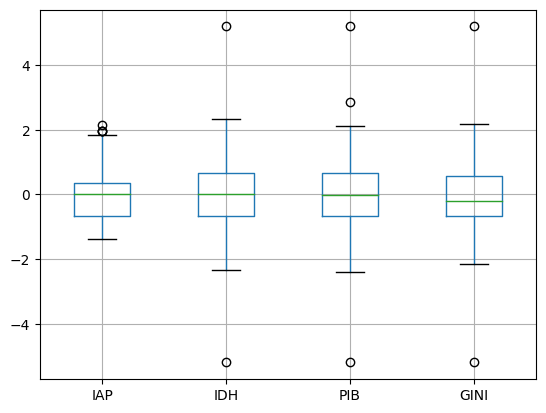

array([[-6.76405278e-01, -6.66821977e-01, -6.72725882e-01,
        -6.50837306e-01],
       [ 2.08844564e-02,  6.93889390e-17, -1.44983131e-03,
        -2.03961176e-01],
       [ 3.47462762e-01,  6.78874479e-01,  6.74524926e-01,
         5.74459993e-01]])

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")
    
    
def print_limits(dataset) -> np.array:

    res = np.zeros((3, 4))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    plt.show()

    #print(f"caps: {caps}")
    #print(f"outliers: {outliers}")
    #print(f"boxes: {boxes}")
    #print(f"medians: {medians}")
    #print(f"whiskers: {whiskers}")


    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]


        # res[0][cont] = lower_range
        # res[1][cont] = Q1
        # res[2][cont] = M
        # res[3][cont] = Q3
        # res[4][cont] = upper_range

        # res[0][cont] = Q1
        # res[1][cont] = M
        # res[2][cont] = Q3
        # res[3][cont] = upper_range

        res[0][cont] = Q1
        res[1][cont] = M
        res[2][cont] = Q3


        cont += 1
    
    
    return res
         

print_limits(scaled_df.iloc[:,2:6])

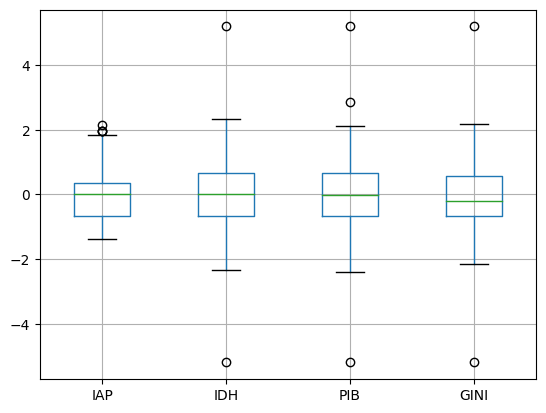

array([[-6.76405278e-01, -6.66821977e-01, -6.72725882e-01,
        -6.50837306e-01],
       [ 2.08844564e-02,  6.93889390e-17, -1.44983131e-03,
        -2.03961176e-01],
       [ 3.47462762e-01,  6.78874479e-01,  6.74524926e-01,
         5.74459993e-01]])

In [38]:
     #IP       #IDH      #PIB      #GINI
Q = [0.0,      0.0,       0.0,      0.0]
P = [2.0,      2.0,       2.0,      2.0]
V = [4.0,      4.0,       4.0,      4.0]
W = [0.5,      0.5,       0.5,      0.1]

B = print_limits(scaled_df.iloc[:,2:6]).tolist()

np.array(B)

In [39]:

###############################################################################

# Required Libraries
import copy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

###############################################################################

# Function: Plot Projected Points 
def plot_points(data, classification):
    plt.style.use('ggplot')
    colors = {'A':'#54FF00', 'B':'#FFEB00', 'C':'#FF9500', 'D':'#FF0000', 'E':'#FF0000', 'F':'#ff796c', 'G':'#04d8b2', 'H':'#ffb07c', 'I':'#aaa662', 'J':'#0485d1', 'K':'#fffe7a', 'L':'#b0dd16', 'M':'#85679', 'N':'#12e193', 'O':'#82cafc', 'P':'#ac9362', 'Q':'#f8481c', 'R':'#c292a1', 'S':'#c0fa8b', 'T':'#ca7b80', 'U':'#f4d054', 'V':'#fbdd7e', 'W':'#ffff7e', 'X':'#cd7584', 'Y':'#f9bc08', 'Z':'#c7c10c'}
    classification_ = copy.deepcopy(classification)
    color_leg = {}
    if (data.shape[1] == 2):
        data_proj = np.copy(data)
    else:
        tSVD      = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
        tSVD_proj = tSVD.fit_transform(data)
        data_proj = np.copy(tSVD_proj)
        #variance  = sum(np.var(tSVD_proj, axis = 0) / np.var(tSVD_proj, axis = 0).sum())
    class_list  = list(set(classification_))
    for i in range(0, len(classification_)):
        classification_[i] = str(classification_[i])
    for i in range(0, len(classification_)):
        for j in range(0, len(class_list)):
            classification_[i] = classification_[i].replace(str(class_list[j]), str(chr(ord('A') + class_list[j])))
    class_list = list(set(classification_))
    class_list.sort() 
    for i in range(0, len(class_list)):
        color_leg[class_list[i]] = colors[class_list[i]]
    patchList = []
    for key in color_leg:
        data_key = mpatches.Patch(color = color_leg[key], label = key)
        patchList.append(data_key)
    for i in range(0, data_proj.shape[0]):
        plt.text(data_proj[i, 0], data_proj[i, 1], 'x' + str(i+1), size = 10, ha = 'center', va = 'center', bbox = dict(boxstyle = 'round', ec = (0.0, 0.0, 0.0), fc = colors[classification_[i]],))
    plt.gca().legend(handles = patchList, loc = 'center left', bbox_to_anchor = (1.05, 0.5))
    axes = plt.gca()
    xmin = np.amin(data_proj[:,0])
    xmax = np.amax(data_proj[:,0])
    #axes.set_xlim([xmin*0.7, xmax*1])
    axes.set_xlim([xmin, xmax*1])
    ymin = np.amin(data_proj[:,1])
    ymax = np.amax(data_proj[:,1])
    if (ymin < ymax):
        axes.set_ylim([ymin, ymax])
    else:
        axes.set_ylim([ymin*0.7, ymax*1])
    plt.show()

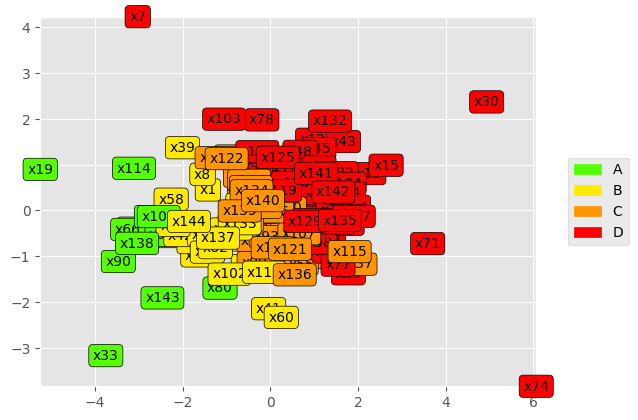

In [40]:
from pyDecision.algorithm import electre_tri_b


classification = electre_tri_b(np.array(scaled_df.iloc[:, 2:6]), W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'pc', graph = False)

plot_points(np.array(scaled_df.iloc[:, 2:6]), classification)


In [53]:
# Required Libraries
import numpy as np
import pandas as pd


from electre_tree import tree_e_tri_b , util_e_tri_b
from sklearn.model_selection import train_test_split

dataset = scaled_df

countries = dataset.iloc[:,1:2]
X         = dataset.iloc[:,2:].values


# ok - Para domingo - aumentar o número de classes e inserir o target.
# Usar o mesmo dataset de antes
# Usar o ELECTRE nesse novo dataset e verificar a otimização
# depois - tentar aumentar o número de gerações.

# Parameters - ELECTRE Tree
rule      = 'pc'
classes   = 4
target    = [1, 2, 2, 2, 2, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 2, 2, 0, 0, 3, 1, 2, 3, 2, 1, 3, 3, 2, 1, 3, 2, 3, 0, 1, 2, 0, 2, 2, 1, 3, 1, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 3, 1, 3, 1, 2, 1, 3, 2, 3, 0, 3, 2, 1, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 0, 3, 1, 3, 1, 2, 2, 2, 3, 0, 0, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 0, 1, 3, 3, 1, 3, 2, 3, 2, 2, 1, 2, 2, 0, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 1, 2, 3, 1, 2, 3, 2, 1, 0, 2, 2, 3, 3, 0, 1]

cut_level = [0.5, 1.0]
Q         = []
P         = []
V         = []
W         = []
B         = []
models    = 100

# Parameters - GA
elite       = 1
eta         = 1
mu          = 2
size        = 15
rate        = 0.05
generations = 30
samples     = 0.10 

In [54]:
# Train Model
models = tree_e_tri_b.tree_electre_tri_b(X, target_assignment = target, W = W, Q = Q, P = P, V = V, B = B, cut_level = cut_level, rule = rule, number_of_classes = classes, elite = elite, eta = eta, mu = mu, population_size = size, mutation_rate = rate, generations = generations, samples = samples, number_of_models = models)   


Model # 1
Model # 2
Model # 3
Model # 4
Model # 5
Model # 6
Model # 7
Model # 8
Model # 9
Model # 10
Model # 11
Model # 12
Model # 13
Model # 14
Model # 15
Model # 16
Model # 17
Model # 18
Model # 19
Model # 20
Model # 21
Model # 22
Model # 23
Model # 24
Model # 25
Model # 26
Model # 27
Model # 28
Model # 29
Model # 30
Model # 31
Model # 32
Model # 33
Model # 34
Model # 35
Model # 36
Model # 37
Model # 38
Model # 39
Model # 40
Model # 41
Model # 42
Model # 43
Model # 44
Model # 45
Model # 46
Model # 47
Model # 48
Model # 49
Model # 50
Model # 51
Model # 52
Model # 53
Model # 54
Model # 55
Model # 56
Model # 57
Model # 58
Model # 59
Model # 60
Model # 61
Model # 62
Model # 63
Model # 64
Model # 65
Model # 66
Model # 67
Model # 68
Model # 69
Model # 70
Model # 71
Model # 72
Model # 73
Model # 74
Model # 75
Model # 76
Model # 77
Model # 78
Model # 79
Model # 80
Model # 81
Model # 82
Model # 83
Model # 84
Model # 85
Model # 86
Model # 87
Model # 88
Model # 89
Model # 90
Model # 91
Model # 

In [59]:
# Predict
prediction, solutions = tree_e_tri_b.predict(models, X, verbose = False, rule = rule)

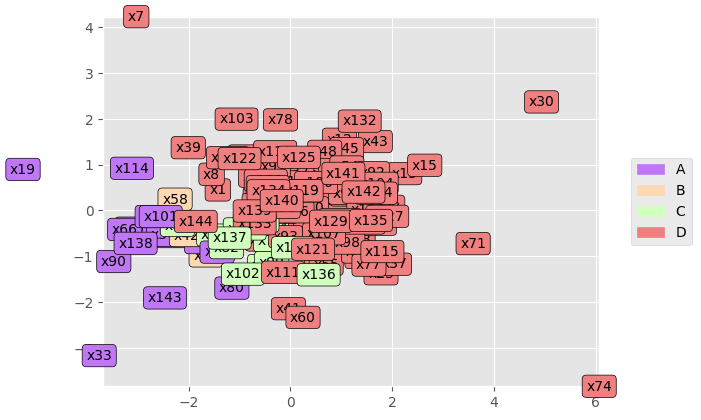

In [60]:
# Plot - Tree Model
util_e_tri_b.plot_points(X, prediction)

In [61]:
# Elicitated Paramneters
w_mean, w_std, q_mean, q_std, p_mean, p_std, v_mean, v_std, b_mean, b_std, cut_mean, cut_std, acc_mean, acc_std = tree_e_tri_b.metrics(models, number_of_classes = classes) 

print('Criteria Weights: ', np.around(w_mean, decimals = 2))
print('Q: ', np.around(q_mean, decimals = 2))
print('P: ', np.around(p_mean, decimals = 2))
print('V: ', np.around(v_mean, decimals = 2))
for i in range(0, len(b_mean)):
  print('b'+str(i+1)+': ', np.around(b_mean[i], decimals = 2))
print('Lambda Cutoff: ', round(cut_mean,  2))
print('Accuracy: ',      round(acc_mean,  2))

Criteria Weights:  [0.52 0.51 0.43 0.33]
Q:  [0.51 0.7  0.86 1.12]
P:  [0.85 1.07 1.31 1.54]
V:  [1.48 1.76 2.18 2.25]
b1:  [-0.49 -0.07  0.46  1.63]
b2:  [0.65 0.93 1.07 1.7 ]
b3:  [1.09 1.35 1.41 1.77]
Lambda Cutoff:  0.73
Accuracy:  0.75


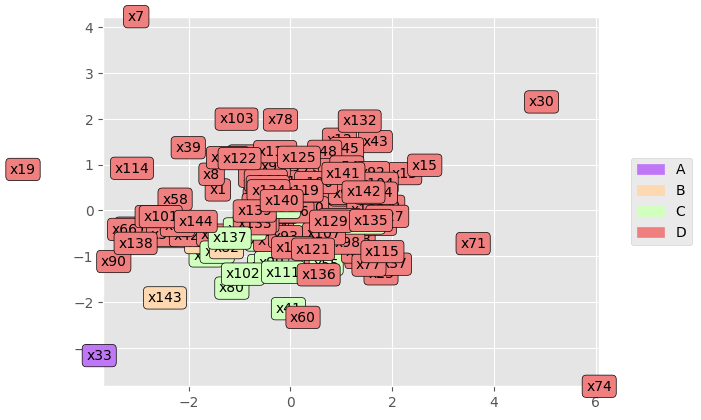

In [62]:
# Plot - Elicitated Parameters
e_tri = util_e_tri_b.electre_tri_b(X, W = w_mean, Q = q_mean, P = p_mean, V = v_mean, B = b_mean, cut_level = cut_mean, verbose = False, rule = rule, graph = True)

In [63]:
# Plot Tree Model - Decision Boundaries
tree_e_tri_b.plot_decision_boundaries(X, models)  

KeyboardInterrupt: 

In [ ]:
# Plot Mean Model - Decision Boundaries  
model_mean = []
model_mean.append([w_mean, acc_mean, [], [], [], b_mean, cut_mean, [], [], q_mean, p_mean, v_mean])
tree_e_tri_b.plot_decision_boundaries(X, model_mean)

In [48]:
scaled_df['CLASS'] = classification

<Figure size 1200x800 with 0 Axes>

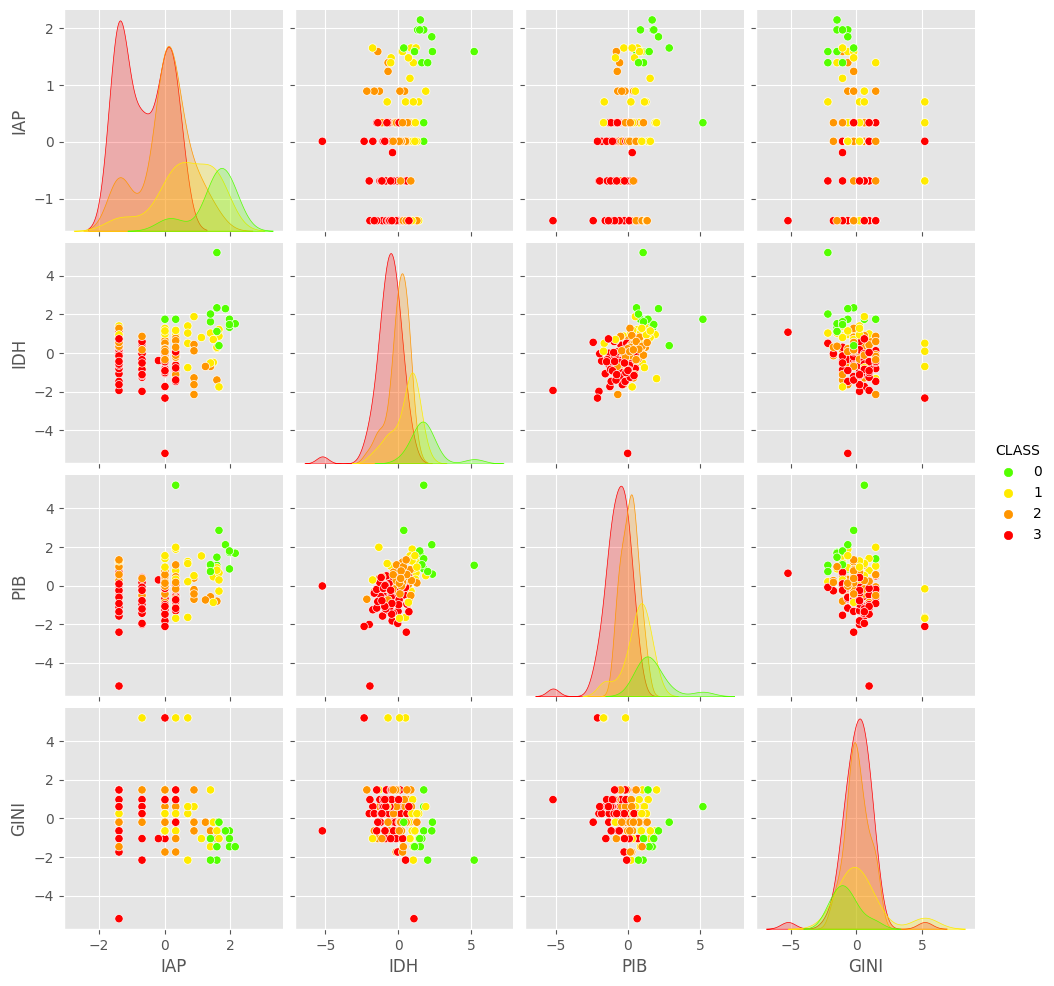

In [59]:
# Gráficos de dispersão múltiplos
import seaborn as sns

plt.figure(figsize=(12, 8))

sns.pairplot(scaled_df.iloc[:, 2:], hue='CLASS', palette=cmap.colors)
plt.show()

In [49]:
#scaled_df.query('CLASS == 3').shape
scaled_df['CLASS'].value_counts()


3    60
2    44
1    26
0    13
Name: CLASS, dtype: int64

In [50]:
scaled_df = scaled_df.rename(index=lambda s: 'x' + str(s + 1))

In [51]:
scaled_df.describe()

,IAP,IDH,PIB,GINI,CLASS
count,1.430000e+02,143.000000,143.000000,143.000000,143.000000
mean,2.111753e-16,0.002627,0.002792,0.064918,2.055944
std,1.003515e+00,1.143351,1.149648,1.323802,0.984215
min,-1.389978e+00,-5.199338,-5.199338,-5.199338,0.000000
25%,-6.886512e-01,-0.666898,-0.669970,-0.650837,1.000000
50%,9.898073e-03,-0.012660,0.000750,-0.203961,2.000000
75%,3.374822e-01,0.681502,0.675503,0.604585,3.000000
max,2.149556e+00,5.199338,5.199338,5.199338,3.000000


In [52]:
import geopandas as gpd

gdf_munic = gpd.read_file('json/munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(scaled_df, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

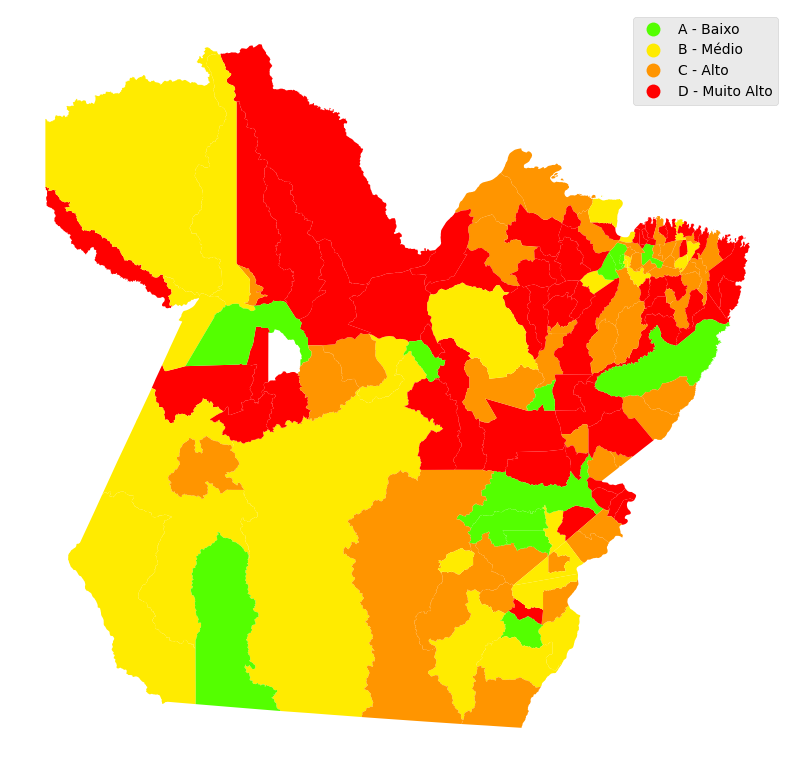

In [53]:
import branca as bc
import folium

#clusdict={5: '1 - Extremely High', 4: '1 - Very High', 3: '2 - High', 2: '3 - Medium', 1: '4 - Low', 0: '5 - Very Low' }
clusdict={3: 'D - Muito Alto', 2: 'C - Alto', 1: 'B - Médio', 0: 'A - Baixo' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)
cmap_r = cmap
ax = gpd_teste.plot(column='classe', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap=cmap_r)

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

In [ ]:
df_teste = df_teste.rename(index=lambda s: 'x' + str(s + 1))

scaled_df['geometry'] = df_teste['geometry']


In [ ]:
scaled_df

In [ ]:
#!pip install folium matplotlib mapclassify

In [ ]:
m = gpd_teste.explore(column='legenda', cmap=cmap_r,tooltip=False, popup=['id', 'legenda','localidade','classe'], style_kwds=dict(color="black",weight=1, opacity=0.4))

m.save("mapas/mapa_interativo.html")

In [ ]:
denuncias = pd.read_json('json/casos_violencia_por_municipio.json')

denuncias = denuncias.rename(index=lambda s: 'x' + str(s + 1))

scaled_df['denuncias'] = denuncias['casos']

In [ ]:
data = pd.concat([df_munic.rename(index=lambda s: 'x' + str(s + 1)), scaled_df.iloc[:,7:8]], axis=1)


sns.set_style("whitegrid")


# depict visualization
gfg = sns.boxplot(x="CLASS", y="denuncias", data=scaled_df, palette='hot_r')

gfg.set_ylim(0, 150)
#('A', 'B', 'C', 'D')
#{0:'A', 1: 'B', 2: 'C', 3: 'D'}
#gfg.set_xlim(scaled_df['CLASS'].map(lambda x: 'A' if 0 elif 'B' if 1))
gfg.set(xlabel ="Classificação", ylabel = "Denúncias")




In [ ]:
df_munic

In [ ]:
result_df = pd.DataFrame()
data2 = scaled_df[['CLASS', 'denuncias', 'IAP', 'IDH','PIB', 'GINI']]

grouped = data2.groupby('CLASS')['denuncias', 'IAP', 'IDH','PIB', 'GINI'].sum()

result = grouped.reset_index()

#result_df = grouped.reset_index().pivot(index='CLASS', columns=['denuncias', 'IAP']).reset_index()

result

In [ ]:
cols = ['green' if x == 0 else ('yellow' if x==1 else ('orange' if x== 2 else 'red')) for x in result.CLASS]

percent_df = pd.DataFrame(scaled_df['CLASS'].value_counts())

sns.stripplot(data=scaled_df, x="CLASS", y="denuncias", palette=cols)


In [ ]:

gfg = sns.barplot(data=result, x='CLASS', y='denuncias', palette=cols)
#gfg = sns.countplot(data=scaled_df.iloc[:, 2:4], y='IAP')
#scaled_df.iloc[:, 2:7]


#gfg = sns.barplot(data=result, x='CLASS' ,y='IDH', color='blue')
#gfg = sns.barplot(data=result, x='CLASS' ,y='IAP', color='red')
#gfg = sns.barplot(data=result, x='CLASS' ,y='PIB', color='green')
#gfg = sns.barplot(data=result, x='CLASS' ,y='GINI', color='purple')

#sns.barplot(data=result, x="CLASS", y='IAP')





In [ ]:
result

In [ ]:
tb = scaled_df.iloc[:, [1,6]].reset_index()


tb.to_excel('listaClassificacao.xlsx')

In [ ]:
gpd_teste = gpd.GeoDataFrame(scaled_df)
cmap_r = cmap
ax = gpd_teste.plot(column='GINI', categorical=True, legend=False, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap=cmap.reversed())

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

#replace_legend_items(ax.get_legend(), clusdict)


ax.set_axis_off()